# **Advanced messages reactions analysis**

This notebook illustrates the study of reaction to messages in a conversation. The analysis presented here is only partially provided by the `conversation_analysis` package, and rather relies on external manipulation of `numpy` arrays and `pandas` dataframes. It is nevertheless useful to anyone willing to get analytics on the reactions in a conversation.

Contents
--------
1. [Setup](#setup)
2. [Reaction usage](#react_usage)
    1. [Types of reactions given](#react_given)
    2. [Types of reactions received](#react_received)
    3. [Evolution of reactions usage](#react_usage)
3. [Number of reactions given and received](#react_count)
4. [Evolution of the fraction of reactions received](#react_frac)
5. [Reaction-to-message ratio](#react_per_msg)
6. [Time evolution of the reaction-to-message ratio](#rolling_react_per_msg)

## <a name="setup"></a>Setup

For this notebook we are going to use the packages `numpy` and `pandas` extensively. We also have to setup a few things before diving into data analysis.

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# set the module directory in sys.path
pdir = Path(os.path.abspath("")).resolve().parent
if not (cdir := str(pdir)) in sys.path:
    sys.path.append(cdir)
from conversation_analysis import (list_messenger_conversations, MessengerConversation,
                                   ConversationStats,
                                   pie_plot, bar_plot, stack_plot)

In [2]:
archive_dir = pdir / 'examples/Messenger_JSON_archive'
conversations = list_messenger_conversations(archive_dir)
conv = MessengerConversation.from_facebook_json(conversations['conversation1_bhmqhe56cg'])

messages_data = conv.messages_data()
reactions_data = conv.reactions_data()

participants = sorted(conv.participants)
reactions = {r: i for i, r in enumerate(np.unique(reactions_data['reaction']))}

genders = {
    'Ada lovelace': 'female',
    'Al-Jazari': 'male',
    'Alan Turing': 'male',
    'Alonzo Church': 'male',
    'Charles Babbage': 'male',
    'Claude Shannon': 'male',
    'Dennis Richie': 'male',
    'Edsger Dijkstra': 'male',
    'Frances Elizabeth Allen': 'female',
    'George Boole': 'male',
    'Grace Hopper': 'female',
    'Haskell Curry': 'male',
    'Ida Rhodes': 'female',
    'John Doe': 'male',
    'John von Neumann': 'male',
    'Joseph-Marie Jacquard': 'male',
    'Lynn Conway': 'female',
    'Stephen Cole Kleene': 'male'
    }

We will have to display emoji on matplotlib figure. However, none of the fonts available with matplotlib can display all emojis. The proposed workaround is to import an external font and use it in figures.

The font OpenSansEmoji can be downloaded [here](https://github.com/MorbZ/OpenSansEmoji) and should be placed in a definite directory (here `~/Fonts/`). Then use `matplotlib.font_manager` to add the font to matplotlib. For those using Apple devices, there is the possibility to use Apple Color Emoji.

This does not solve completely the issue, however, since the emoji will appear monochromatic. This is possibly due to the default matplotlib backend having limited support for emojis. See here for a tedious workaround [https://nfraprado.net/post/using-emojis-in-matplotlib.html](https://nfraprado.net/post/using-emojis-in-matplotlib.html).

In [3]:
from matplotlib import font_manager

# Load fonts from ~/Fonts/
font_dirs = [Path(os.path.expanduser('~')) / 'Fonts']
for font in font_manager.findSystemFonts(font_dirs):
    font_manager.fontManager.addfont(font)

# Monochromatic emojis will be displayed.
font_family = [
    'DejaVu Sans', # default font
    'OpenSansEmoji', # https://github.com/MorbZ/OpenSansEmoji
    'Twemoji Mozilla', # in "Mozilla Firefox/fonts/" if you have it installed
    'Symbola', # https://www.fontspace.com/symbola-font-f22021
    ]

Finally, we define some utility functions which will come in handy later on.

In [4]:
from collections import Counter

def count(arr: np.ndarray, entries)-> np.ndarray:
    """
    Count the number of occurences of each element of `entries` in `arr`.
    (zero if no occurences)

    `entries` can be any sequence of hashable objects, preferably sorted.
    """
    c = Counter(arr)
    return np.array([c[elt] for elt in entries], dtype=int)


def reaction_counts_dataframe(groups,
                              actors: np.ndarray,
                              reactions: np.ndarray,
                              merge_thr: int = 0)-> pd.DataFrame:
    """
    Build a DataFrame of reaction counts with reactions as index and
    participants as columns.
    
    Reactions which total count among all participants is below `merge_thr` are
    merged into the token 'other'.
    """
    # get reactions to merge (if their total count is <= the threshold)
    ur, rc = np.unique(reactions, return_counts=True)
    merge = [r for r, c in zip(ur, rc) if c <= merge_thr]
    # change such reactions to 'other', get unique reactions
    mod_reactions = np.where(np.isin(reactions, merge), 'other', reactions)
    ureactions = np.unique(mod_reactions)
    # compute unique pairs (participant, reaction) and counts
    pairs = np.stack((actors, mod_reactions), axis=1)
    upairs, counts = np.unique(pairs, return_counts=True, axis=0)
    # build dataframe
    groups = {g: i for i, g in enumerate(groups)}
    ureactions = {r: i for i, r in enumerate(np.unique(mod_reactions))}
    data = np.zeros((len(ureactions), len(groups)), dtype=int)
    for (p, r), k in zip(upairs, counts):
        data[ureactions[r], groups[p]] = k
    
    df_dict = {'index': sorted(ureactions), 'columns': sorted(participants),
               'index_names': ['reaction'], 'column_names': ['group'],
               'data': data,}
    
    return pd.DataFrame.from_dict(df_dict, orient='tight')

## <a name="react_usage"></a>Types of reactions given and received

In this section, we consider the reaction usage. Contrary to what is done elsewhere, the data here is centered around the different reactions rather than the groups/participants.

### <a name="react_received"></a>Received reactions

The count of distinct reactions received per participant cannot be computed easily by the `ConversationStats` class. We must use the function `reaction_counts_dataframe` defined above.

In [5]:
# 'sender' is the message sender, who receives the reaction
recv_df = reaction_counts_dataframe(
    participants, reactions_data['sender'], reactions_data['reaction'])
recv_df

group,Ada lovelace,Al-Jazari,Alan Turing,Alonzo Church,Charles Babbage,Claude Shannon,Dennis Richie,Edsger Dijkstra,Frances Elizabeth Allen,George Boole,Grace Hopper,Haskell Curry,Ida Rhodes,John von Neumann,Joseph-Marie Jacquard,Lynn Conway,Stephen Cole Kleene
reaction,,,,,,,,,,,,,,,,,
👍,55,46,4,31,14,24,40,3,48,0,19,17,39,9,3,15,10
👎,3,0,0,7,0,0,0,0,2,0,1,1,2,0,0,2,0
😆,37,36,9,67,11,11,19,5,34,0,8,7,39,9,8,9,21
😍,39,37,10,55,14,9,24,4,28,0,21,9,25,4,1,6,9
😠,11,12,0,4,1,3,0,2,5,0,2,2,11,0,0,2,1
😢,14,22,3,26,0,3,3,5,10,0,6,3,11,0,0,0,3
😮,20,39,1,49,9,6,16,5,16,0,16,3,16,1,10,5,11


In [6]:
# Aggregate participants by gender for a smaller plot
idx = recv_df.columns.map(lambda x: genders[x]).set_names(['group'])
gender_recv_df = recv_df.T.set_index(idx).groupby(level='group').sum().T
gender_recv_df

group,female,male
reaction,,
👍,176,201
👎,10,8
😆,127,203
😍,119,176
😠,31,25
😢,41,68
😮,73,150


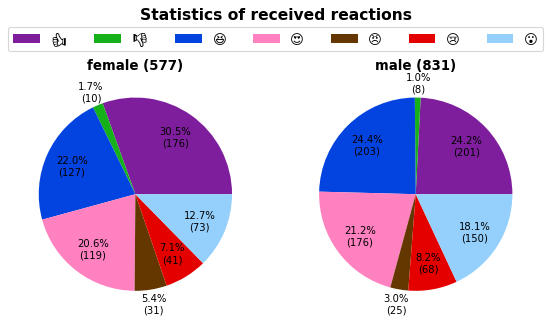

In [7]:
fontprop = font_manager.FontProperties(family=font_family, size=12)
legend_kw = {'ncols': 7, 'prop': fontprop, 'bbox_to_anchor': (0.5, 0.94)}
fig, axs = pie_plot(gender_recv_df, legend_kw=legend_kw, dpi=80)
_ = fig.suptitle("Statistics of received reactions",
                 y=0.98, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/react_pc_recv-react.png") # 'pc' stands for pie chart

### <a name="react_given"></a>Reactions given

The procedure is similar to that for the received reactions. Just replace in `reaction_counts_dataframe` the list of participants who received each reaction by that of those who gave it: `reactions_data['actor']`.

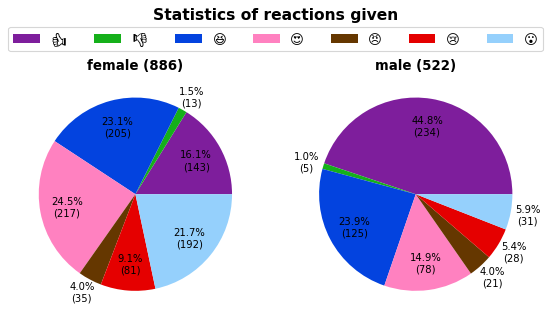

In [8]:
# 'actor' is the reaction actor, who gives the reaction
giv_df = reaction_counts_dataframe(
    participants, reactions_data['actor'], reactions_data['reaction'])
idx = giv_df.columns.map(lambda x: genders[x]).set_names(['group'])
gender_giv_df = giv_df.T.set_index(idx).groupby(level='group').sum().T

fig, axs = pie_plot(gender_giv_df, legend_kw=legend_kw, dpi=80)
_ = fig.suptitle("Statistics of reactions given",
                 y=0.98, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/react_pc_giv-react.png")

### <a name="react_usage"></a>Evolution of reactions usage

We can track the reaction usage over time with a rolling sum. The `ConversationStats` object must be instanciated by selecting the reaction as the group rather that the participants. Then the `rolling_sum` gives the desired result.

Beware though, as possibly many distinct reactions have been used. This will yield an exessively long legend in the plot. We may therefore replace those reactions only seldom used by a token such as `'other'` as done in the function `reaction_counts_dataframe`. This is achieved by the following block of code (useless for this example since not many reactions have been used).

In [9]:
# Replace reactions with total count <= merge_thr by a token 'other'
merge_thr = 20
rfilt = [r for r, c in Counter(reactions_data['reaction']).items() if c > merge_thr]
mod_reactions = np.where(np.isin(reactions_data['reaction'], rfilt), reactions_data['reaction'], 'other')

In [10]:
reaction_usage = ConversationStats(
    reactions_data['timestamp'], mod_reactions,
    {'nb_reactions': np.ones_like(reactions_data['timestamp'])})

reaction_usage_df = reaction_usage.rolling_sum(
    sampling_freq='5D', window_size=10, win_type='gaussian',
    win_args={'std': 2}, period=None, groups=None, timespan=None)
reaction_usage_df

quantity                                                          nb_reactions  \
group                                                                    other   
year month day hour minute second microsecond timestamp                          
2017 3     25  0    0      0      0           1490400000000000000     0.391933   
           30  0    0      0      0           1490832000000000000     0.414007   
     4     4   0    0      0      0           1491264000000000000     0.467121   
           9   0    0      0      0           1491696000000000000     0.509239   
           14  0    0      0      0           1492128000000000000     0.574369   
...                                                                        ...   
2018 4     9   0    0      0      0           1523232000000000000     0.543880   
           14  0    0      0      0           1523664000000000000     0.463805   
           19  0    0      0      0           1524096000000000000     0.352674   
           24  0    0      0      0           1524528000000000000     0.250051   
           29  0    0      0      0           1524960000000000000     0.155903   

quantity                                                                      \
group                                                                      👍   
year month day hour minute second microsecond timestamp                        
2017 3     25  0    0      0      0           1490400000000000000   7.170893   
           30  0    0      0      0           1490832000000000000   7.562400   
     4     4   0    0      0      0           1491264000000000000   8.455533   
           9   0    0      0      0           1491696000000000000   9.584796   
           14  0    0      0      0           1492128000000000000  11.090406   
...                                                                      ...   
2018 4     9   0    0      0      0           1523232000000000000   7.035557   
           14  0    0      0      0           1523664000000000000   7.375761   
           19  0    0      0      0           1524096000000000000   7.596189   
           24  0    0      0      0           1524528000000000000   7.556010   
           29  0    0      0      0           1524960000000000000   7.131858   

quantity                                                                     \
group                                                                     😆   
year month day hour minute second microsecond timestamp                       
2017 3     25  0    0      0      0           1490400000000000000  3.173929   
           30  0    0      0      0           1490832000000000000  3.930736   
     4     4   0    0      0      0           1491264000000000000  4.614578   
           9   0    0      0      0           1491696000000000000  5.080865   
           14  0    0      0      0           1492128000000000000  5.438949   
...                                                                     ...   
2018 4     9   0    0      0      0           1523232000000000000  7.086727   
           14  0    0      0      0           1523664000000000000  6.447696   
           19  0    0      0      0           1524096000000000000  5.648278   
           24  0    0      0      0           1524528000000000000  4.896827   
           29  0    0      0      0           1524960000000000000  4.342944   

quantity                                                                     \
group                                                                     😍   
year month day hour minute second microsecond timestamp                       
2017 3     25  0    0      0      0           1490400000000000000  3.099974   
           30  0    0      0      0           1490832000000000000  3.741628   
     4     4   0    0      0      0           1491264000000000000  4.401748   
           9   0    0      0      0           1491696000000000000  4.874375   
           14  0    0      0      0           1492128000000000000  5.1

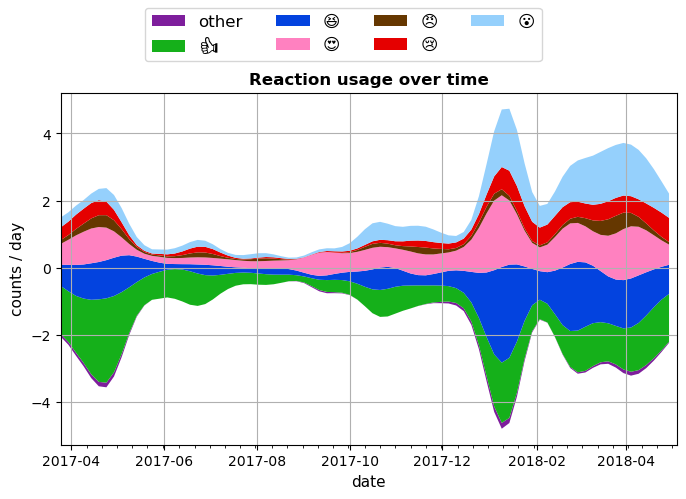

In [11]:
fig, ax = stack_plot(reaction_usage_df['nb_reactions'], baseline='wiggle',
                      timescale='day', xlabel_strftime='%Y-%m', dpi=100,
                      legend_kw={'prop': fontprop, 'ncols': 4})
_ = ax.set_title('Reaction usage over time', fontweight='bold')
_ = ax.set_xlim(0, 35_000_000) # seconds
# fig.savefig("./figures and data/react_sp_react-usage.png") # 'sp' stands for stack plot

## <a name="react_count"></a>Number of reactions given and received

This is a somewhat standard analysis. However, the lists of `'actors'` and `'senders'` usually have different lengths (a message can have zero or more than one reactions). The easiest way to combine the two in a single dataframe is to create it manually. For this purpose, we again use the function `count` defined above.

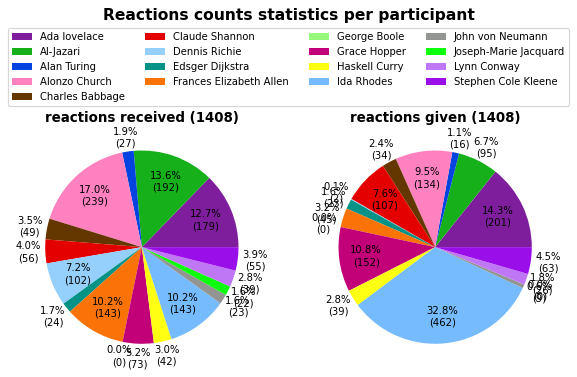

In [12]:
react_data = np.stack((count(reactions_data['sender'], participants),
                       count(reactions_data['actor'], participants)),
                      axis=1)
react_count_df = pd.DataFrame(react_data, index=sorted(participants),
                              columns=['reactions received', 'reactions given'])

fig, axs = pie_plot(react_count_df, legend_kw={'bbox_to_anchor': (0.5, 0.94)}, dpi=80)
_ = fig.suptitle("Reactions counts statistics per participant",
                 y=0.98, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/react_pc_count_participant.png")

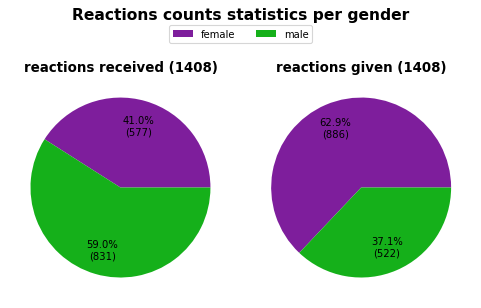

In [13]:
# Aggregate by gender
idx = react_count_df.index.map(lambda x: genders[x]).set_names(['group'])
df = react_count_df.set_index(idx).groupby(level='group').sum()
fig, axs = pie_plot(df, legend_kw={'bbox_to_anchor': (0.5, 0.94)}, dpi=80)
_ = fig.suptitle("Reactions counts statistics per gender",
                 y=0.98, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/react_pc_count_gender.png")

## <a name="react_count"></a>Time evolution of the fraction of reactions received

The fraction of reactions received for each participant sums to 1. It is interesting to see how this fraction evolves in time for each participant. This can be instructive to the mood, an event if life, and so on.

The same analysis can be done for the fraction of reactions given.

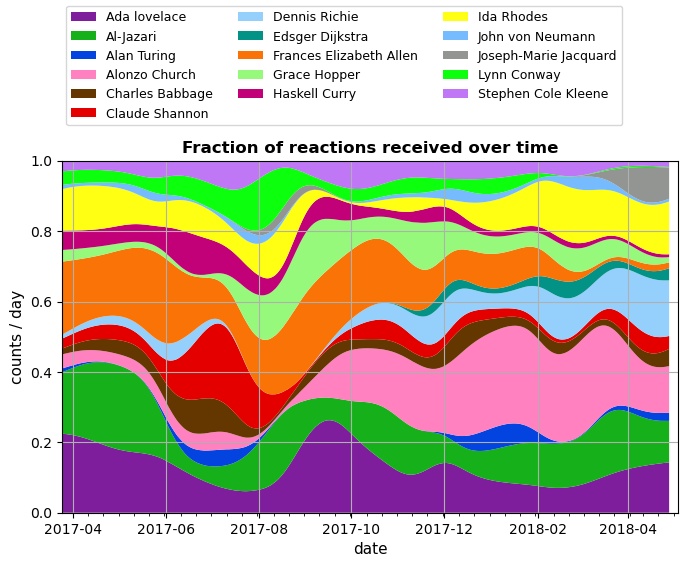

In [14]:
react_frac = ConversationStats(
    reactions_data['timestamp'], reactions_data['sender'],
    {'nb_reactions': np.ones_like(reactions_data['timestamp'])})
react_frac_df = react_frac.rolling_sum(
    sampling_freq='1D', window_size=100, win_type='gaussian',
    win_args={'std': 15}, period=None, groups=None, timespan=None)
react_frac_df = react_frac_df['nb_reactions']
row_sum = react_frac_df.sum(axis=1).replace(0., 1.)
react_frac_df = react_frac_df.div(row_sum, axis=0)

# care about the scaling
fig, ax = stack_plot(react_frac_df, baseline='zero',
                     timescale='day', xlabel_strftime='%Y-%m', dpi=100)
ax.set_xlim(0, 35_000_000) # seconds
ax.set_ylim(0, 1)
_ = ax.set_title('Fraction of reactions received over time', fontweight='bold')
# fig.savefig("./figures and data/react_sp_recv-frac.png")

## <a name="react_per_msg"></a>Reaction-to-message ratio

Another use case of the `count` function. Here we compute the average number of reactions received per message for each participant. Being a ratio, there is no easy interpreation for any plot of this quantity, so we stick to the numerical data. 

In [15]:
msg_sent = count(messages_data['sender'], participants)
react_giv = count(reactions_data['actor'], participants)
react_recv = count(reactions_data['sender'], participants)

ratio_df_dict = {
    'messages_sent': msg_sent,
    'reactions_given': react_giv,
    'reactions_received': react_recv,
    '# reaction received per message': react_recv/np.where(msg_sent == 0, 1, msg_sent),
    }
ratio_df = pd.DataFrame(ratio_df_dict, index=sorted(participants))
ratio_df

,messages_sent,reactions_given,reactions_received,# reaction received per message
Ada lovelace,3391,201,179,0.052787
Al-Jazari,2819,95,192,0.068109
Alan Turing,352,16,27,0.076705
Alonzo Church,3688,134,239,0.064805
Charles Babbage,573,34,49,0.085515
Claude Shannon,1081,107,56,0.051804
Dennis Richie,735,2,102,0.138776
Edsger Dijkstra,93,23,24,0.258065
Frances Elizabeth Allen,2043,45,143,0.069995
George Boole,0,0,0,0.000000


## <a name="rolling_react_per_msg"></a>Time evolution of the reaction-to-message ratio

It can be interesting to plot the evolution of the ratio computed above as a function of time, for the same reason as the fraction of reactions. It gives information about external events, or events in the participants life, or a general tendency to use more or less reactions.

Here we can observe the gradual adoption of the message reaction system.

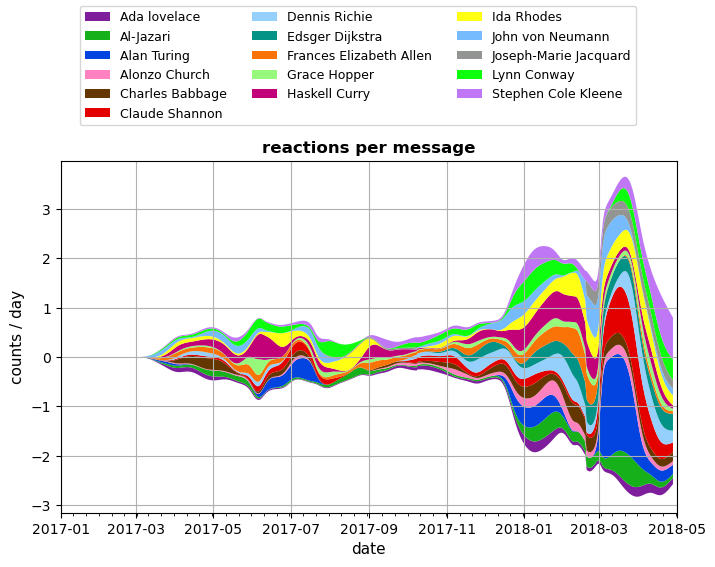

In [16]:
messages_stats = ConversationStats(
    messages_data['timestamp'], messages_data['sender'],
    {'nb_reactions': messages_data['nb_reactions'],
     'nb_messages': np.ones_like(messages_data['timestamp'])})
rolling_df = messages_stats.rolling_sum(
    sampling_freq='1D', window_size=100, win_type='gaussian',
    win_args={'std': 8}, period=None, groups=None, timespan=None)
rolling_df['nb_messages'] = rolling_df['nb_messages'].replace(0., 1.)

rolling_ratio_df = rolling_df['nb_reactions'] / rolling_df['nb_messages']

fig, ax = stack_plot(rolling_ratio_df, baseline='weighted_wiggle',
                     timescale='day', xlabel_strftime='%Y-%m', dpi=100)
_ = ax.set_title('reactions per message', fontweight='bold')
# fig.savefig("./figures and data/react_sp_recv-msg-ratio.png")